<a href="https://colab.research.google.com/github/matheusfbonfim/CNN-Face-Mask-Detection/blob/main/CNN_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


## **[0] IMPORTANDO BIBLIOTECAS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
# Sequential model 
from keras.models import Sequential
# Bibliotecas - Camadas
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten, Dropout 
# Funcão de custo
from keras.metrics import categorical_crossentropy
# Pre-Processamento de imagens
from keras.preprocessing.image import ImageDataGenerator
# P/ salvar o modelo
from keras.callbacks import ModelCheckpoint
# Matriz de confusão
from sklearn.metrics import confusion_matrix
# Plotar o modelo 
from keras.utils.vis_utils import plot_model


import itertools
import os 
import shutil
import matplotlib.pyplot as plt

## **[1] PRÉ-PROCESSAMENTO DE DADOS DE IMAGEM**

Dataset: https://github.com/prajnasb/observations

*   Organizaremos nossos dados em conjuntos de treinamento, validação e teste -> Manualmente  
*   Movendo subconjuntos de dados para subdiretórios - Conjunto de dados separado.



In [ ]:
# Caminhos para os dados de treinamento, validação e teste

path_train = '/content/drive/MyDrive/Colab Notebooks/database/Database-Github/Train'            # Caminho - Train
path_valid = '/content/drive/MyDrive/Colab Notebooks/database/Database-Github/Validation'       # Caminho - Validação
path_test = '/content/drive/MyDrive/Colab Notebooks/database/Database-Github/Test'              # Caminho - Teste

# path_train = '/content/drive/MyDrive/Colab Notebooks/database/Face Mask Dataset/Train'        # Caminho - Train
# path_valid = '/content/drive/MyDrive/Colab Notebooks/database/Face Mask Dataset/Validation'   # Caminho - Validação
# path_test = '/content/drive/MyDrive/Colab Notebooks/database/Face Mask Dataset/Test'          # Caminho - Teste

# path_train = '/content/drive/MyDrive/Colab Notebooks/database/New Masks Dataset/Train'        # Caminho - Train
# path_valid = '/content/drive/MyDrive/Colab Notebooks/database/New Masks Dataset/Validation'   # Caminho - Validação
# path_test = '/content/drive/MyDrive/Colab Notebooks/database/New Masks Dataset/Test'          # Caminho - Teste

### **[1.1] Gerando o conjunto de dados de treinamento, validação/teste**


#### **[1.1.1] ImageDataGenerator**

- Usaremos a funcionalidade Image Data Generator de Keras para lidar com nossos dados de entrada
- No modelo de CNN é preciso colocar os dados em um formato que o modelo espera. Sabe-se que quando treinamos um modelo sequencial Keras, o modelo recebe os dados sempre que chamamos a função de treino (fit)
- Contribui substituindo as imagens de treinamento originais por versões aumentadas das mesmas, enquanto o modelo é treinado nelas. 

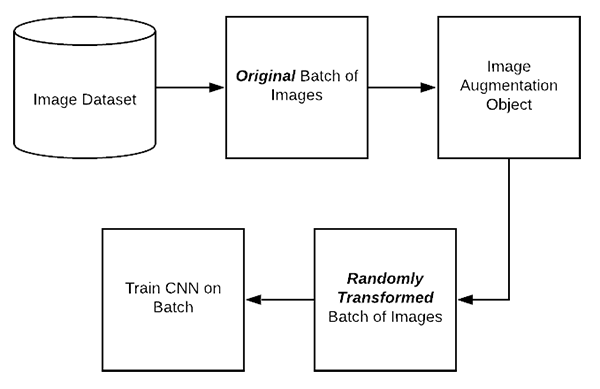

- Colocando as imagens no formato de keras generator  - gerador e um iterador
 - Será criado lotes de dados do diretório onde os dados estão.

-  Com o uso do ImageDataGenerator têm-se variações da mesma imagem, assim significa que durante cada época, uma dessas imagens distorcidas ou aumentadas (depende dos parametros configurados) será enviada através de cada camada de nossa rede neural ao invés da imagem original.

- Assim, o modelo recebe diferentes versões da imagem original, cada uma diferindo em ângulo de rotação, zoom, etc. durante cada iteração.

- Vale ressaltar que com o uso é possível evitar o *sobreajuste*, pois o modelo é treinado em diferentes versões da imagem sempre que é passado por diferentes camadas do modelo.

In [ ]:
# shear_range - significa que a imagem será distorcida ao longo de um eixo
# zoom_range - Amplia aleatoriamente a imagem e adiciona novos valores de pixel ao redor da imagem ou interpola valores de pixel respectivamente
train_gen = ImageDataGenerator(rescale = 1.0/255.0, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)                                                                                                
valid_gen = ImageDataGenerator(rescale = 1.0/255.0)
test_gen =  ImageDataGenerator(rescale = 1.0/255.0)

- Normalizacao de pixels: Os valores RGB variam de 0 a 255 (8 bits), mas no modelo iremos usar intervalos que sejam de 0 a 1 -> rescale = 1.0/255
- **OBS**: Apenas as imagens de train devem conter aumentos e não as imagens usadas para validação / teste. Isto posto, adicionamos inversões, zoom e rotações aos dados de treinamento, enquanto simplesmente redimensionamos os dados de validação e teste.


#### **[1.1.2] Flow_from_directory**

- Chama-se o **fluxo de diretorio**, no qual é passado os dados reais e especificado como queremos que esses dados sejam processados
 - **`directory`** - É definido o diretório igual ao caminho do conjunto de dados 
 - **`target_size`** - Altura e largura que as imagens devem ter - redimensiona todas as imagens 
 - **`classes`** - Os rótulos potenciais do conjunto 
 - **`batch_size`** -  Tamanho de lote (Por exemplo, se você tiver 1000 imagens em seu conjunto de dados e o tamanho do lote for definido como 10. Então, o "ImageDataGenerator" produzirá 10 imagens em cada iteração do treinamento. Uma iteração é definida como etapas por época, ou seja, o número total de amostras / tamanho do lote. No caso, em cada época de treinamento haverá 100 iterações.)

In [ ]:
train_batches = train_gen.flow_from_directory(directory = path_train, batch_size = 32 , color_mode= 'rgb' ,target_size=(200, 200), seed = 42, class_mode = 'binary')
valid_batches = valid_gen.flow_from_directory(directory = path_valid, batch_size = 32 , color_mode= 'rgb' ,target_size=(200, 200), seed = 42, class_mode = 'binary')
test_batches = test_gen.flow_from_directory(directory = path_test, batch_size = 32,  color_mode= 'rgb', target_size=(200, 200), seed = 42, class_mode = 'binary')

Found 1315 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


- Dado que o parâmetro **`class_mode`** seja atribuido como '**`binary`**', a variavel train_gen (variável geradora de dados de imagem), ao recuperar imagens de cada pasta, os rotula automaticamente em classes com mascara e sem mascara, isso dependendo de quais pastas foram armazenados. 

In [ ]:
# Vendo os rotulos e os dados gerados
train_batches.class_indices # Rede neural precisa de indices categoricos em formato inteiro

{'with_mask': 0, 'without_mask': 1}

### **[1.2] Verificando as imagens**


In [ ]:
# Pegando um unico lote de imagens e as labels  do train_batches
images , labels = next(train_batches) # Deve haver 32 imagens (Tamanho do batch)

In [ ]:
# Plotando as imagens do lote acima
  # Esta função irá traçar imagens na forma de uma grade com 1 linha e 10 colunas onde as imagens são colocadas
def plotingImages(images_array):
    fig, axes = plt.subplots(4, 8, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img)
        ax.axis('off') # Desliga os eixos em torno de cada imagem
    
    plt.tight_layout()
    plt.show()

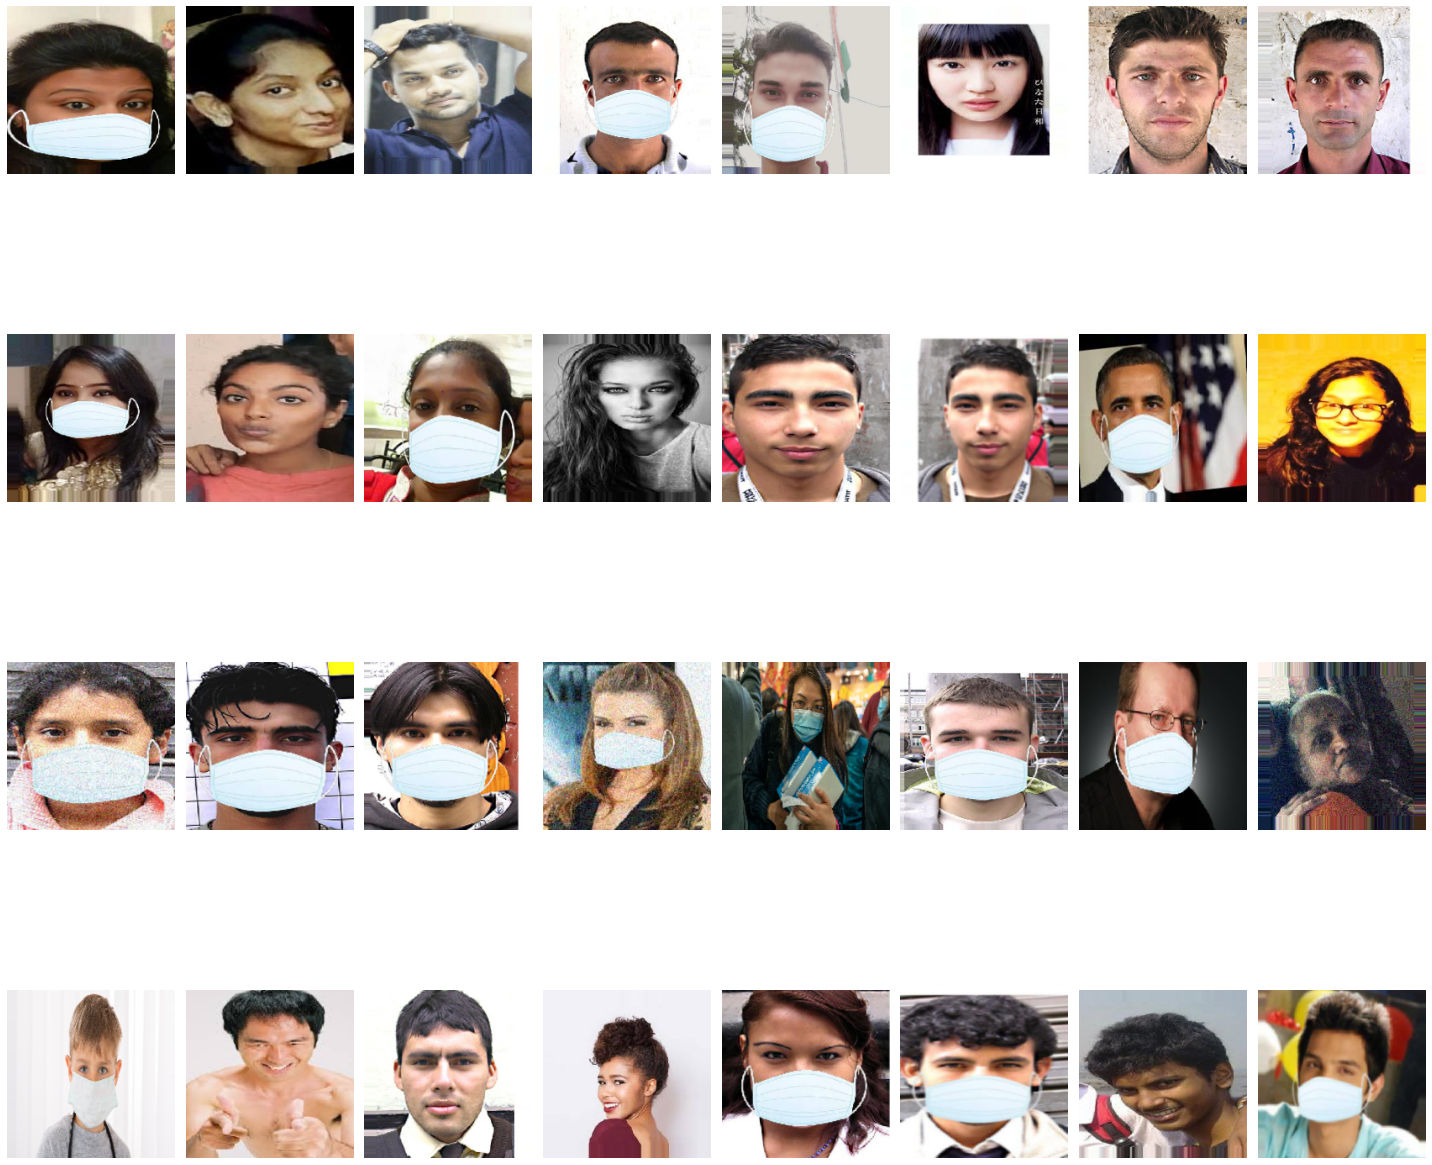

[0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0.]


In [ ]:
plotingImages(images) # Visualizado apenas 64 imagens 
print(labels)

## **[2] MODELO - REDE NEURAL CONVOLUCIONAL**

In [ ]:
images.shape # Os dados de treinamento são imagens de pessoas: 32 amostras, cada uma com 200 por 200 pixels, e com ultima dimensão de 3 canais devido ao RGB

(32, 200, 200, 3)

### **[2.1] Construindo o modelo**

In [ ]:
## INICIANDO O MODELO

# Modelo como uma pilha simples de camadas onde cada camada tem exatamente um tensor de entrada e um tensor de saída .
model = Sequential()

**Inserindo a camada convolucional**

- Terá 200 filtros com um tamanho de kernel de 3x3 (escolha muito comum para dados de imagem)
- Função de ativação relu
- Preenchimento igual (Nossas imagens terão o preenchimento de zero do lado de fora para que a dimensionalidade das imagens não sejam reduzidas após as operacões de convolução)
- **`input_shape`** - É especificado a forma de entrada dos dados

In [ ]:
# A primeira camada está conectada a todos os pixels na imagem de entrada
model.add(Conv2D(filters = 200, kernel_size = (3, 3), activation = 'relu', input_shape=(200,200,3)))

**MaxPooling**

- Tamanho do pool 2 por 2 e nossos passos em 2
- Corta as dimensões da imagem 
- O pooling é necessário para reduzir a amostra da detecção de recursos em mapas de recursos
- Após gerado o mapa de ativações é realizado seu agrupamento, normalmente utilizando a função Max Pooling, que agrupa regiões do mapa de ativações mantendo apenas o maior valor de cada região, assim gerando um mapa de ativações mais compacto e mantendo sua principais ativações

In [ ]:
model.add(MaxPooling2D(pool_size=(2, 2)))

**Inserindo outra camada convolucional**

- Terá 64 filtros com um tamanho de kernel de 3x3 (escolha muito comum para dados de imagem)

In [ ]:
model.add(Conv2D(filters = 100, kernel_size = (3, 3), activation = 'relu'))

**MaxPooling**

- Tamanho do pool 2 por 2 e nossos passos em 2
- Corta as dimensões da imagem 
- O pooling é necessário para reduzir a amostra da detecção de recursos em mapas de recursos

In [ ]:
model.add(MaxPooling2D(pool_size=(2, 2)))

**Flatten**

- Nivela-se toda camada em um tensor unidimensional antes de passar para camada de densa

In [ ]:
model.add(Flatten())

model.add(Dropout(0.5)) # O dropout é uma técnica usada para evitar que um modelo seja superdimensionado

**MLP**


In [ ]:
# Redes densamente conectadas - Cada unidade em cada camada está conectada a todas unidades na camada anterior
  # Usaremos 50 unidades
  # Função de ativacao = relu
model.add(Dense(50, activation='relu'))

# Saida da rede é uma camada totalmente conectada com uma unidade para cada classe: 2 tipos
  # Usa a função de ativação softmax para decidir qual das tres classes foi apresentada
    # Nos dá a probabilidade para cada saída correspondente
model.add(Dense(2, activation='softmax')) 

### **[2.2] Visualizando o modelo**

In [ ]:
# summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 200)     5600      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 200)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 97, 97, 100)       180100    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 230400)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 230400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)               

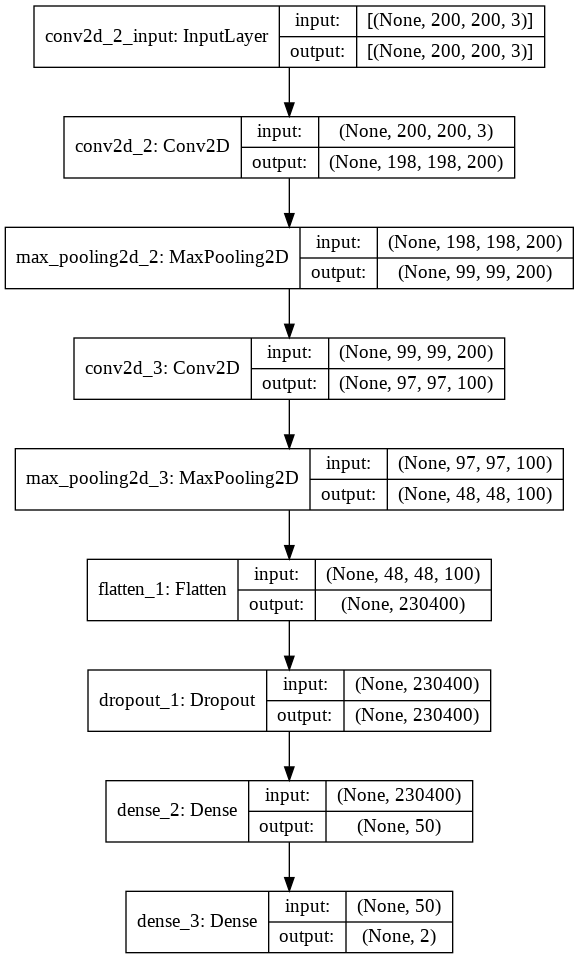

In [ ]:
# Plotando o modelo
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/model/plot_model.png', show_shapes=True, show_layer_names=True)

**Exemplo de diagrama de rede convolucional**

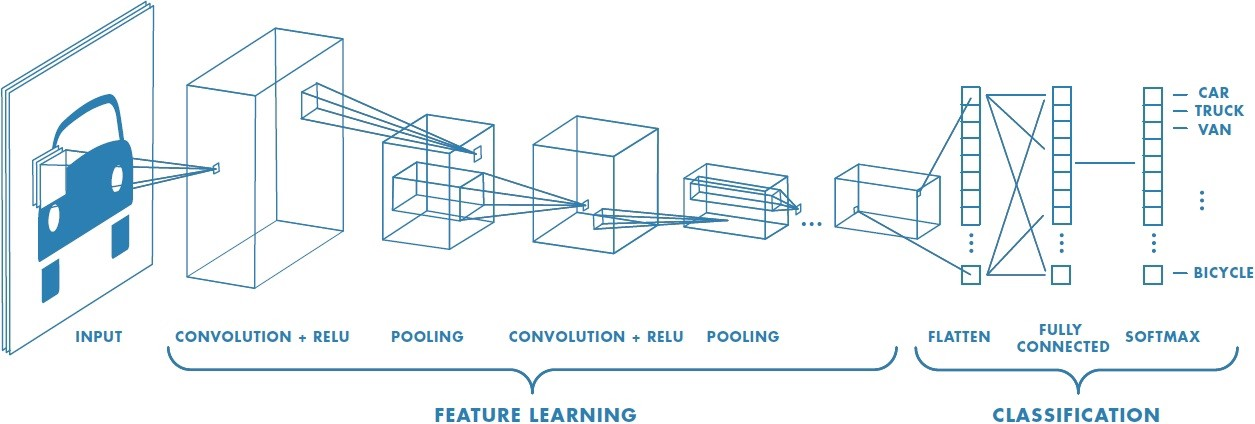

### **[2.3] Compilando o modelo**

- **Otimizador adam:**

1.   Adam é um algoritmo de otimização que pode ser usado em vez do     procedimento clássico de descida de gradiente estocástico para atualizar os pesos da rede iterativos com base nos dados de treinamento.

- **Função de custo:  categorical_crossentropy**

1.   Também chamado de perda de Softmax . É uma ativação do Softmax mais uma perda de entropia cruzada . Se usarmos essa perda, vamos treinar uma CNN para emitir uma probabilidade ao longo do classes para cada imagem. É usado para  classificação multiclasse.

- **`metrics['accuracy']`**

1.   Indica ao modelo que relate a precisão





In [ ]:
# Compilamos o modelo
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

### **[2.4] Treinando o modelo**

- Durante o treinamento, a rede ajusta seus pesos por meio da retropopagação e descida do gradiente
- Podemos analisar os dados varias vezes até que a rede possa classificar as imagens com precisão
- O modelo será executado por 20 epocas, o que significa que examinará todos os dados de treinamento 20 vezes
- Em cada epoca, o programa acompanha o progresso no conjunto de dados (Loss function e accuracy)

### **[2.5] Validando o modelo**
- É de preocupação que o algoritmo possa se ajustar demais aos dados de treinamento. Ou seja, pesos resultam em um erro muito pequeno no conjunto de treinamento, mas não generalizam bem para outro conjunto de dados.

- Para evitar o ajuste excessivo, separamos um conjunto de imagens de validação

- No final de cada epoca de treinamento, testaremos o modelo neste conjunto de validação

- Abaixo foi usado o `valid_bacthes` das imagens para validação em `validation_data`

In [ ]:
# ModelCheckpoint - o retorno de chamada é usado em conjunto com o treinamento model.fit() para 
# salvar um modelo ou pesos (em um arquivo de ponto de verificação) em algum intervalo, para que 
# o modelo ou pesos possam ser carregados posteriormente para continuar o treinamento a partir do estado salvo.
model_save = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/model/face-detector-model.h5', monitor = 'val_loss', verbose = 0, save_best_only=True, mode = 'auto')

In [ ]:
# Fit to training data
  # Quando os dados são armazenados como um gerador, o proprio gerador realmente contem o rotulos e não precisamos 
  # especificar separadamente
history = model.fit(x=train_batches, validation_data=valid_batches, epochs = 20, callbacks=[model_save],steps_per_epoch = len(train_batches))

Epoch 1/20
42/42 [==============================] - 480s 11s/step - loss: 0.8495 - accuracy: 0.6973 - val_loss: 0.4778 - val_accuracy: 0.8028
Epoch 2/20
42/42 [==============================] - 489s 12s/step - loss: 0.3129 - accuracy: 0.8821 - val_loss: 0.1396 - val_accuracy: 0.9437
Epoch 3/20
42/42 [==============================] - 490s 12s/step - loss: 0.1780 - accuracy: 0.9323 - val_loss: 0.1481 - val_accuracy: 0.9577
Epoch 4/20
42/42 [==============================] - 487s 12s/step - loss: 0.1460 - accuracy: 0.9468 - val_loss: 0.0911 - val_accuracy: 0.9648
Epoch 5/20
42/42 [==============================] - 483s 11s/step - loss: 0.1245 - accuracy: 0.9536 - val_loss: 0.0923 - val_accuracy: 0.9648
Epoch 6/20
42/42 [==============================] - 486s 12s/step - loss: 0.1088 - accuracy: 0.9650 - val_loss: 0.1489 - val_accuracy: 0.9648
Epoch 7/20
42/42 [==============================] - 495s 12s/step - loss: 0.1180 - accuracy: 0.9582 - val_loss: 0.0634 - val_accuracy: 0.9718
Epoch 

### **[2.6] Testando o modelo**

- Outra avaliação do modelo deve ser feita em um conjunto de testes separado que não foi usado durante o treinamento. 
- Nós da uma avaliação realista e separada da qualidade do modelo
 - Perda 
 - Precisão

In [ ]:
# Evaluate on test data 
model.evaluate(test_batches)

7/7 [==============================] - 23s 3s/step - loss: 0.1045 - accuracy: 0.9639


[0.1045437678694725, 0.9639175534248352]

**Predição de uma imagem do dataset**

In [ ]:
#For Predicting on single Image
from keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/Colab Notebooks/database/Database-Github/Test/with_mask/1-with-mask.jpg', target_size = (200,200,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(f"Result: {result}")
#answer = model.predict_classes(test_image)
#train_generator.class_indices
if result[0][0]==1:
    prediction = 'mask'
else :
    prediction = 'unmask'
print(prediction)

Result: [[1. 0.]]
mask


### **[2.7] Analisando os dados**

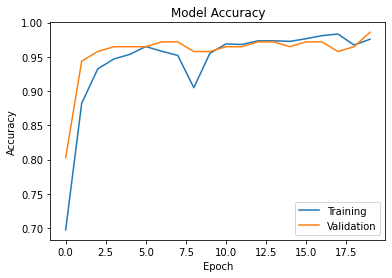

In [ ]:
# SUMARIO - HISTORICO DA ACURACIA
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/model/history_accuracy.png', format='png')
plt.show()

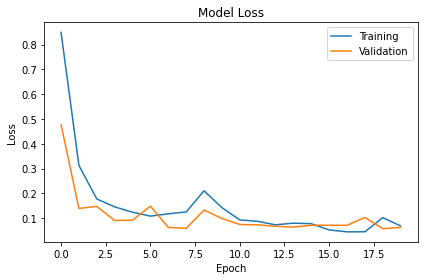

In [ ]:
# SUMARIO - HISTORICO DA FUNCAO DE CUSTO
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/model/history_loss.png', format='png')
plt.tight_layout()

plt.show()